# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Импорты и констансы

In [20]:
import os
import random
import re
from tqdm import tqdm
tqdm.pandas()


from PIL import Image
from pathlib import Path


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns


import torch
import torchvision.transforms as transforms
import torchvision.models as mdls


from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, GroupShuffleSplit


from tensorflow import keras
from tensorflow.keras import layers
from IPython.display import display

In [2]:
PATH = '/Users/vs/Programming/Data Science/Data-Science-Projects/18. new/df'
TRAIN_DATA_PATH = '/Users/vs/Programming/Data Science/Data-Science-Projects/18. new/df/train_images'
TEST_DATA_PATH = '/Users/vs/Programming/Data Science/Data-Science-Projects/18. new/df/test_images'
RANDOM_STATE = 42
CHILD_WORDS = ["children", "teenager", "baby", "child", "youth", "girl", "boy",
                "infant", "toddler", "youngster", "adolescent", "teen", "kid",
                "student", "pupil", "grandchild", "sister", "brother", "nephew", 
                "niece", "daughter", "son"]

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [3]:
train_data = pd.read_csv(os.path.join(PATH, 'train_dataset.csv'))
train_data.name = 'train_data'
data_crowd = pd.read_csv(os.path.join(PATH, 'CrowdAnnotations.tsv'), sep='\t', names = ['image', 'query_id', 'fraction', 'pros', 'cons'])
data_crowd.name = 'data_crowd'
data_expert = pd.read_csv(os.path.join(PATH, 'ExpertAnnotations.tsv'), sep='\t', names = ['image', 'query_id', 'first', 'second', 'third'])
data_expert.name = 'data_expert'
test_query = pd.read_csv(os.path.join(PATH, 'test_queries.csv'), index_col=[0], sep='|')
test_query.name = 'test_query'
test_image = pd.read_csv(os.path.join(PATH, 'test_images.csv'))
test_image.name = 'test_image'

In [4]:
for dataframe in [train_data, data_crowd, data_expert, test_query, test_image]:
    print('------------------------------------------------------------------------------------------------------------')
    print('+-------------+')
    print(f'| {dataframe.name}  |')
    print('+-------------+')
    display(dataframe.sample(5))
    print()

------------------------------------------------------------------------------------------------------------
+-------------+
| train_data  |
+-------------+


image                     query_id  \
4316  2631300484_be8621d17b.jpg  3482062809_3b694322c4.jpg#2   
3740  3688858505_e8afd1475d.jpg  2522297487_57edf117f7.jpg#2   
1548  1348304997_afe60a61df.jpg  2718024196_3ff660416a.jpg#2   
3671  3396157719_6807d52a81.jpg  2968182121_b3b491df85.jpg#2   
4816  3490736665_38710f4b91.jpg  3347666612_659e6e2207.jpg#2   

                                             query_text  
4316  A woman posing with a statue alongside a group...  
3740  a white woman in a green sweater holds a smili...  
1548  A little boy is leaping in the air onto a wate...  
3671                              Two greyhounds race .  
4816         Two children playing in a spray of water .


------------------------------------------------------------------------------------------------------------
+-------------+
| data_crowd  |
+-------------+


image                     query_id  fraction  pros  \
6137   2105756457_a100d8434e.jpg  2274992140_bb9e868bb8.jpg#2       0.0     0   
47504   917574521_74fab68514.jpg  2431832075_00aa1a4457.jpg#2       0.0     0   
24800  3113322995_13781860f2.jpg   113678030_87a6a6e42e.jpg#2       0.0     0   
28350  3228069008_edb2961fc4.jpg  3216926094_bc975e84b9.jpg#2       0.0     0   
18033  2788945468_74a9618cfa.jpg  2667015110_1670324a33.jpg#2       0.0     0   

       cons  
6137      3  
47504     3  
24800     3  
28350     3  
18033     3


------------------------------------------------------------------------------------------------------------
+-------------+
| data_expert  |
+-------------+


image                     query_id  first  second  \
3223   317383917_d8bfa350b6.jpg   317383917_d8bfa350b6.jpg#2      4       4   
3398  3217910740_d1d61c08ab.jpg  3421789737_f625dd17ed.jpg#2      1       1   
5079   396360611_941e5849a3.jpg  2103568100_5d018c495b.jpg#2      2       2   
5714   771048251_602e5e8f45.jpg  1765164972_92dac06fa9.jpg#2      1       2   
1899  2621415349_ef1a7e73be.jpg   491405109_798222cfd0.jpg#2      1       1   

      third  
3223      4  
3398      2  
5079      2  
5714      2  
1899      1


------------------------------------------------------------------------------------------------------------
+-------------+
| test_query  |
+-------------+


query_id  \
208  3036971334_78187a9570.jpg#3   
422  3730011701_5352e02286.jpg#2   
354  3459871361_92d1ecda36.jpg#4   
352  3459871361_92d1ecda36.jpg#2   
201  3033612929_764d977bd5.jpg#1   

                                            query_text  \
208   People stand by a rocky cliff with water below .   
422  A little girl with a hat sits between a woman ...   
354  Young man on a trick bicycle jumps at the top ...   
352  A skateboarder jumping on a graffiti covered r...   
201  A small white dog is carrying something blue i...   

                         image  
208  3036971334_78187a9570.jpg  
422  3730011701_5352e02286.jpg  
354  3459871361_92d1ecda36.jpg  
352  3459871361_92d1ecda36.jpg  
201  3033612929_764d977bd5.jpg


------------------------------------------------------------------------------------------------------------
+-------------+
| test_image  |
+-------------+


image
42  3520936130_9e90872560.jpg
25  3722572342_6904d11d52.jpg
74  3170110692_d1e0e66cee.jpg
66  1319634306_816f21677f.jpg
48  2308256827_3c0a7d514d.jpg

/var/folders/70/k39t_x2d08g08hls8fkylcyr0000gn/T/ipykernel_24662/934132979.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/70/k39t_x2d08g08hls8fkylcyr0000gn/T/ipykernel_24662/934132979.py:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


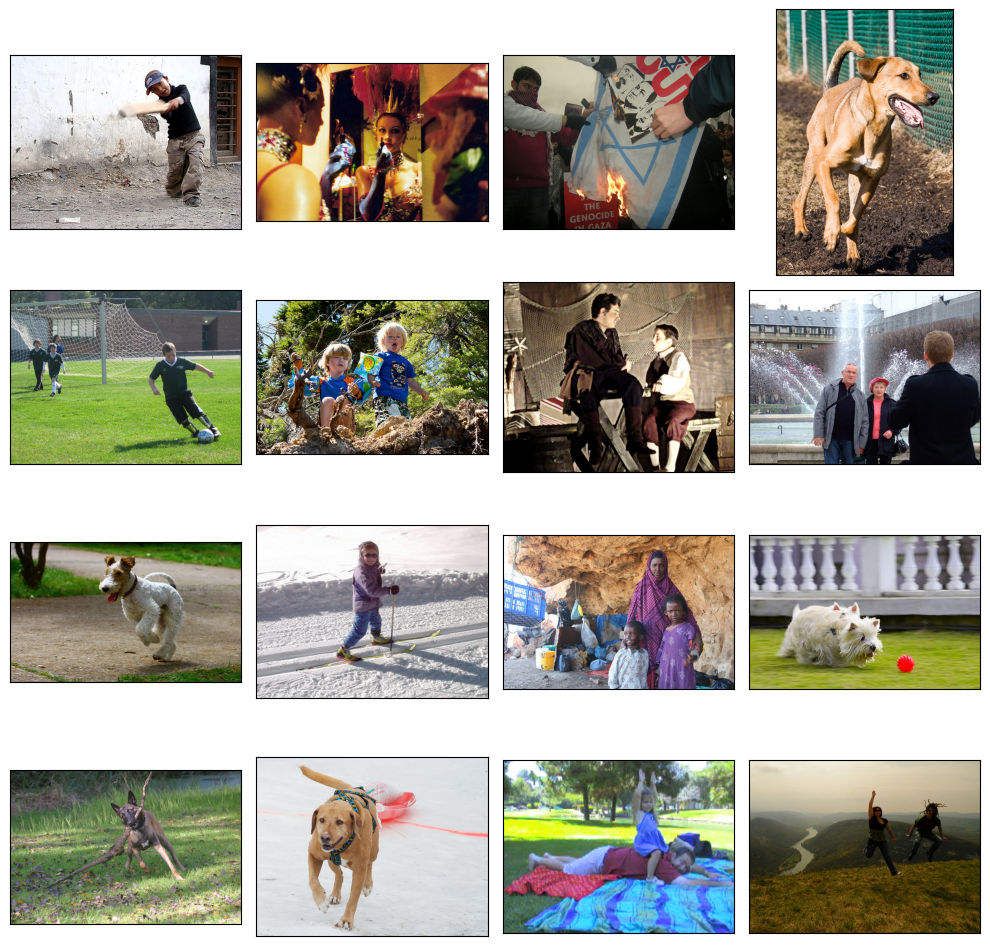

In [5]:
samples_train = list(train_data['image'].sample(8))
samples_test = list(test_query['image'].sample(8))

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'train_images', samples_train[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
for i in range(8):
    fig.add_subplot(4, 4, i+9)
    image = Image.open(Path(PATH, 'test_images', samples_test[i]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Имея в наличии экспертные и краудсорсинговые оценки соответствия текста и изображения, а также обучающий и тестовый датасеты, мы готовы к агрегации оценок. Процесс агрегации включает объединение оценок с использованием метода агрегации. Сначала мы нормализуем экспертные оценки от 1 до 4 до диапазона [0, 1]. Затем, для вычисления итоговой оценки, применяется взвешенное среднее между масштабированными оценками экспертов и долей краудсорсинга. Коэффициент для оценок экспертов составляет 0.6, в то время как для оценок краудсорсинга - 0.4. Это позволяет учесть как экспертные мнения, так и коллективное мнение группы людей при формировании окончательной оценки. Однако перед этим шагом мы удаляем все строки с отсутствующими данными.

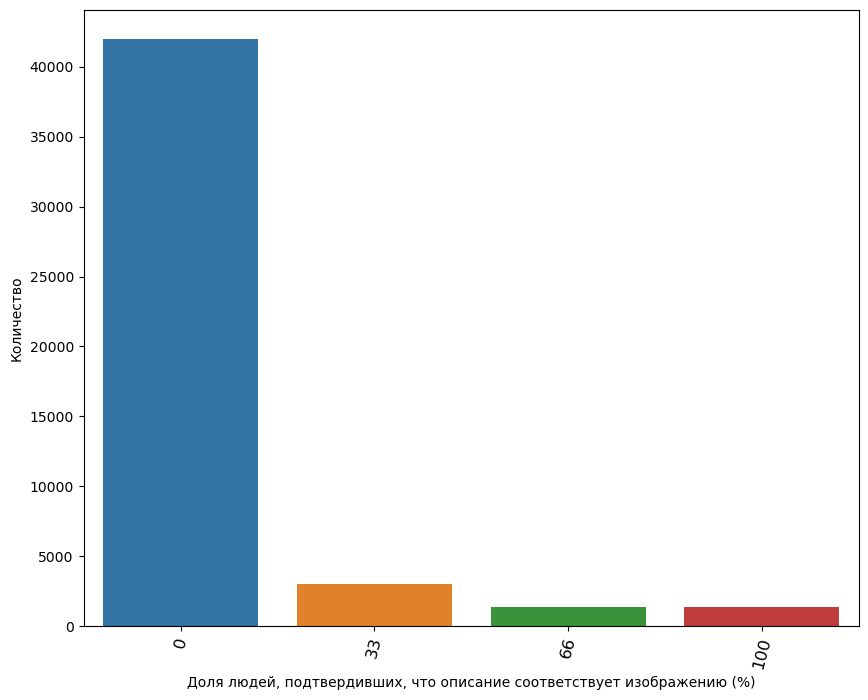

In [6]:
crowd_analicit = data_crowd.copy()
crowd_analicit['fraction'] *= 100
crowd_analicit['fraction'] = crowd_analicit['fraction'].astype('int')
crowd_array=[]
fraction_nums = np.array([0, 33, 66, 100])
for i in fraction_nums:
    crowd_array.append((crowd_analicit['fraction'] == i).sum())
    
plt.figure(figsize=(10, 8))
sns.barplot(x = fraction_nums, y = crowd_array)
plt.xticks(rotation=75, size=12)
plt.xlabel('Доля людей, подтвердивших, что описание соответствует изображению (%)')
plt.ylabel('Количество')
plt.show()

In [7]:
# Renaming columns for convenience
data_crowd.columns = ['image', 'description', 'crowd_ratio', 'crowd_for', 'crowd_against']
data_expert.columns = ['image', 'description', 'expert1', 'expert2', 'expert3']

# Merging data based on description identifier
merged_annotations = pd.merge(data_crowd, data_expert, on=['image', 'description'])

# Creating lists to store rows that need to be removed
rows_to_remove = []

# Checking that each row has both image, description, and ratings
for index, row in train_data.iterrows():
    image_id = row['image']
    description_id = row['query_id']

    # Checking for the presence of image and description in merged_annotations
    if (image_id not in merged_annotations['image'].values) or (description_id not in merged_annotations['description'].values):
        rows_to_remove.append(index)

# Removing rows with missing data
train_data.drop(rows_to_remove, inplace=True)

# Aggregation method for ratings (majority voting with probability consideration)
def aggregate_scores(row):
    expert_scores = [row['expert1'], row['expert2'], row['expert3']]
    crowd_probability = row['crowd_ratio']

    # Scaling expert ratings from 1 to 4 into the range [0, 1]
    scaled_expert_scores = (pd.Series(expert_scores) - 1) / 3

    # Weighted average of scaled expert ratings and crowd sourcing ratio
    weight_expert = 0.6  # Weight of experts 
    weight_crowd = 0.4   # Weight of crowd sourcing 

    final_probability = (scaled_expert_scores.mean() * weight_expert) + (crowd_probability * weight_crowd)
    return final_probability

# Applying the aggregation method
merged_annotations['final_score'] = merged_annotations.apply(aggregate_scores, axis=1)

train_data = pd.merge(train_data, merged_annotations[['image', 'final_score']], on='image', how='left')
train_data = train_data.drop_duplicates().reset_index(drop=True)

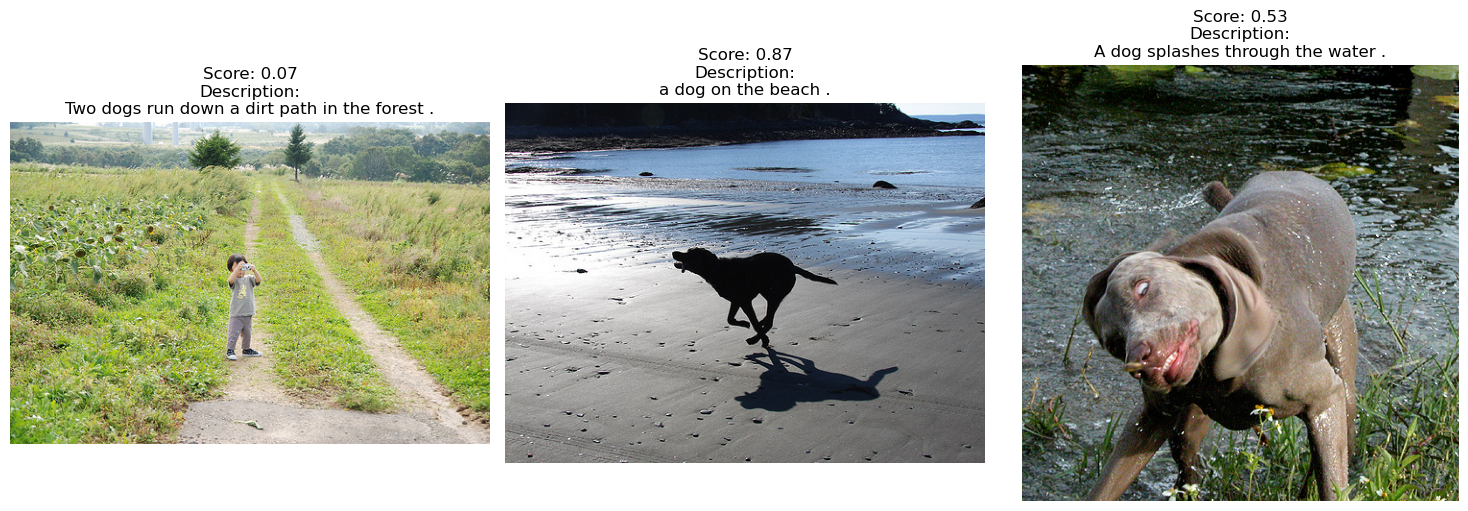

In [8]:
# Choosing random rows from merged annotations
random_rows = merged_annotations.sample(3)

# Creating a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, row in enumerate(random_rows.itertuples()):
    # Getting the path to the image (replace 'train_path' with the path to your images)
    image_path = os.path.join('/Users/vs/Programming/Data Science/Data-Science-Projects/18. new/df/train_images', row.image)

    # Displaying the image on the corresponding subplot
    image = plt.imread(image_path)
    axes[i].imshow(image)
    axes[i].axis('off')

    # Displaying the description and merged score below the image
    description_text = train_data[train_data['query_id'] == row.description]['query_text'].values[0] if not train_data[train_data['query_id'] == row.description].empty else "Description not found."
    axes[i].set_title(f"Score: {row.final_score:.2f}\nDescription:\n{description_text}")

plt.tight_layout()
plt.show()

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [9]:
# Creating a dictionary for counting mentions
word_counts = {word: 0 for word in CHILD_WORDS}

# Counting mentions of each word in the descriptions
for description in train_data['query_text']:
    for word in CHILD_WORDS:
        if word in description.lower():
            word_counts[word] += 1

# Sorting words by the number of mentions in descending order
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Printing words and their counts
for word, count in sorted_word_counts:
    print(f"Word '{word}' appears {count} times")


Word 'boy' appears 1029 times
Word 'girl' appears 952 times
Word 'child' appears 545 times
Word 'son' appears 423 times
Word 'children' appears 183 times
Word 'kid' appears 161 times
Word 'baby' appears 108 times
Word 'toddler' appears 83 times
Word 'student' appears 27 times
Word 'youth' appears 8 times
Word 'teen' appears 7 times
Word 'teenager' appears 0 times
Word 'infant' appears 0 times
Word 'youngster' appears 0 times
Word 'adolescent' appears 0 times
Word 'pupil' appears 0 times
Word 'grandchild' appears 0 times
Word 'sister' appears 0 times
Word 'brother' appears 0 times
Word 'nephew' appears 0 times
Word 'niece' appears 0 times
Word 'daughter' appears 0 times


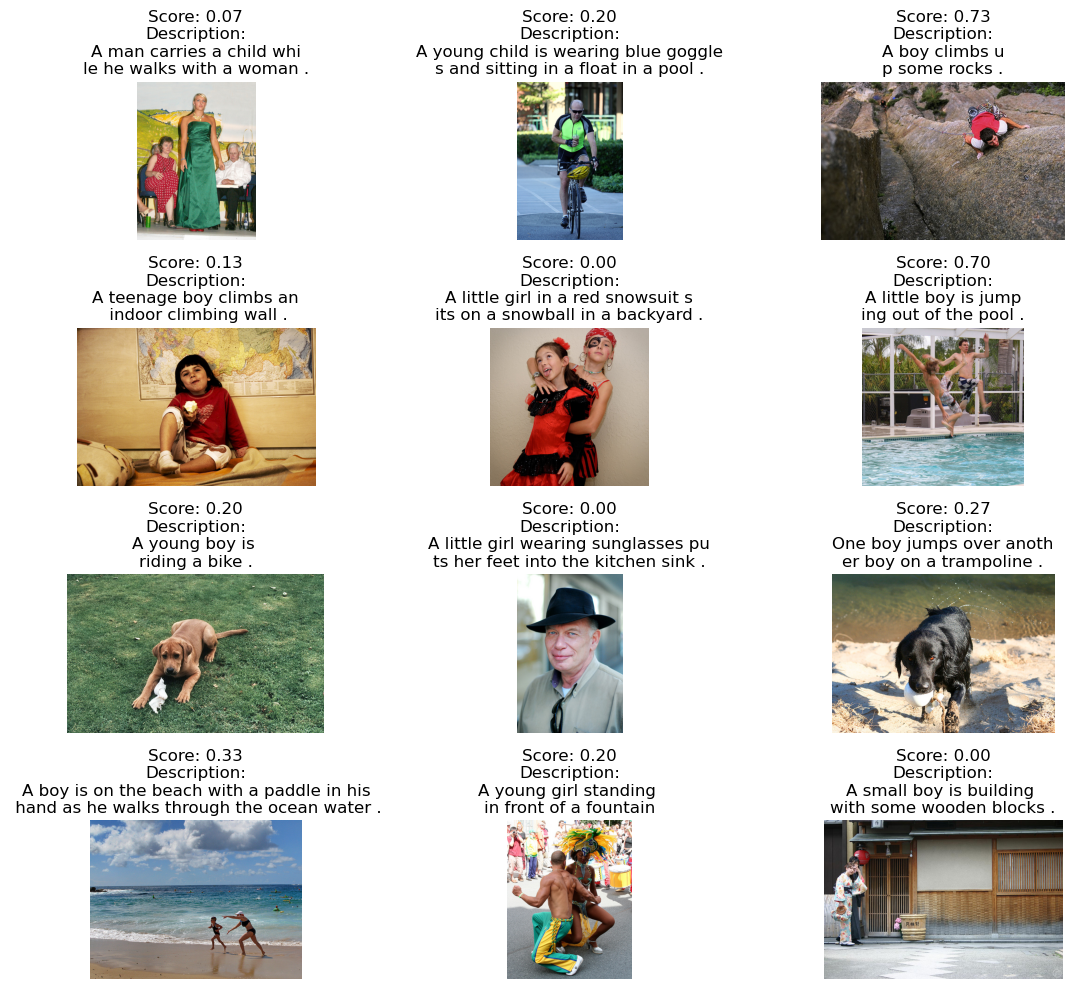

In [10]:
# Creating a regular expression for finding keywords
pattern = r'\b(?:' + '|'.join(re.escape(word) for word in CHILD_WORDS) + r')\b'

# Using the regular expression to filter descriptions
filtered_descriptions = train_data[train_data['query_text'].str.lower().str.contains(pattern, regex=True)]

# Checking if there are at least 12 suitable descriptions
if len(filtered_descriptions) >= 12:
    random_images = random.sample(filtered_descriptions['image'].tolist(), 12)

    fig, axes = plt.subplots(4, 3, figsize=(12, 10))
    axes = axes.ravel()

    for i, image_name in enumerate(random_images):
        image_row = merged_annotations[merged_annotations['image'] == image_name]
        if not image_row.empty:
            description = filtered_descriptions[filtered_descriptions['image'] == image_name]['query_text'].values[0]
            final_score = image_row['final_score'].values[0]

            image_path = os.path.join(TRAIN_DATA_PATH, image_name)
            image = mpimg.imread(image_path)
            axes[i].imshow(image)
            axes[i].set_title(f"Score: {final_score:.2f}\nDescription:\n{description[:len(description)//2]}\n{description[len(description)//2:]}")
            axes[i].axis('off')
        else:
            print(f"Image file name: {image_name}")
            print("Score not found.\n")

    for i in range(len(random_images), 12):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
else:
    print("Not enough suitable descriptions to display 12 images.")


In [11]:
# Using the regular expression to filter descriptions and create a new DataFrame
filtered_descriptions = train_data[train_data['query_text'].str.contains(pattern, case=False, regex=True)]

# Removing rows where at least one keyword is present in the description
df_train = train_data[~train_data['query_text'].str.contains(pattern, case=False, regex=True, na=False)]


В ходе анализа обнаружено, что на многих изображениях присутствуют дети. Однако не наблюдается прямой связи между оценками и качеством изображений. Например, некоторые изображения, получившие оценку 0, все равно содержат детей. Также на изображениях встречаются животные, включая собак (с фразами "хороший мальчик", "хорошая девочка"). Хотя для решения данной задачи было бы полезно обучить модель компьютерного зрения, данные в нашем распоряжении несколько отличаются. Поэтому предлагается просто удалить все изображения, содержащие хотя бы одно из слов из заданного списка. Хотя это может привести к удалению части изображений с животными, это предпочтительнее, чем сохранение изображений с детьми.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [12]:
# Loading the pretrained ResNet-18 model
model = mdls.resnet18(pretrained=True)
model = model.eval()

# Image preprocessing before feeding into the model
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function for vectorizing an image
def vectorize_image(image_path, model, preprocess):
    image = Image.open(image_path)
    image = preprocess(image)
    image = image.unsqueeze(0)
    
    with torch.no_grad():
        features = model(image)
    
    return features.numpy()

# Iterating through all rows in df_train and vectorizing images
image_vectors = []

for image_name in df_train['image']:
    image_path = os.path.join(TRAIN_DATA_PATH, image_name)
    if os.path.exists(image_path):  # Checking if file exists
        vectorized_image = vectorize_image(image_path, model, preprocess)
        image_vectors.append(vectorized_image)
    else:
        print(f"File not found: {image_path}")

# Converting vectors to a numpy array
if len(image_vectors) > 0:
    image_vectors = np.vstack(image_vectors)
else:
    print("No image vectors found.")

# Now you should have an array image_vectors with vectorized images.
# You can use it for combining with vectorized text and training your model.


/Users/vs/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
image_vectors.shape

(8744, 1000)

Мы применили предварительно обученную модель ResNet-18 для векторизации изображений. Это позволило нам получить массив размером (8744, 1000).

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [14]:
# Creating an instance of TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

# Vectorizing text from the 'query_text' column and obtaining the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(df_train['query_text'])

# Converting the matrix to a NumPy array
text_vectors = tfidf_matrix.toarray()

# Printing the dimensionality of the vectors
print("Dimensionality of text vectors:", text_vectors.shape)

Dimensionality of text vectors: (8744, 925)


В данном участке кода мы использовали модель Word2Vec для векторизации текстовых описаний фотографий. Сначала мы провели токенизацию текстов и обучили модель Word2Vec. Затем создали функцию для векторизации каждого описания путем усреднения векторов слов. В случае отсутствия слова в модели, мы использовали нулевой вектор. В итоге получили массив векторов размером (8744, 925).

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [15]:
# Creating a DataFrame for image and text vectors
vector_df = pd.DataFrame(np.hstack((image_vectors, text_vectors)), columns=[f"image_vector_{i}" for i in range(image_vectors.shape[1])] + [f"text_vector_{i}" for i in range(text_vectors.shape[1])])

# Adding the target column final_score
vector_df['final_score'] = df_train['final_score'].values

# Now vector_df contains all vectors and the target column


На данном этапе мы успешно объединили векторы изображений и текстовых описаний для подготовки данных к обучению. Мы создали матрицу, в которой каждой фотографии соответствует усредненный вектор её текстовых описаний. Это позволит нам в дальнейшем использовать объединенные данные для обучения модели, учитывая и визуальные, и текстовые характеристики изображений.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [16]:
# Creating a GroupShuffleSplit object
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)

# Performing the dataset split into training and testing sets
train_indices, test_indices = next(gss.split(X=vector_df.drop(columns=['final_score']), y=vector_df['final_score'], groups=df_train['image']))

# Creating the training and testing datasets
train_df, test_df = vector_df.loc[train_indices], vector_df.loc[test_indices]

In [17]:
# List of models and their names
model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Neural Network']
models = [
    LinearRegression(),
    RandomForestRegressor(random_state=RANDOM_STATE),
    GradientBoostingRegressor(random_state=RANDOM_STATE),
    keras.Sequential([
        layers.Input(shape=(len(train_df.columns) - 1,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
]

# List to store results
results = []

# Training and evaluating models
for model, model_name in zip(models, model_names):
    if isinstance(model, keras.Sequential):
        # Training neural network
        model.compile(optimizer='adam', loss='mean_squared_error')
        history = model.fit(train_df.drop(columns=['final_score']), train_df['final_score'], epochs=20, batch_size=32, validation_data=(test_df.drop(columns=['final_score']), test_df['final_score']), verbose=0)
        mse = history.history['val_loss'][-1]
    else:
        # Training other models
        model.fit(train_df.drop(columns=['final_score']), train_df['final_score'])
        y_pred = model.predict(test_df.drop(columns=['final_score']))
        mse = mean_squared_error(test_df['final_score'], y_pred)

    results.append({'Model': model_name, 'MSE': mse})

# Creating a results table and sorting by MSE
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='MSE')

# Displaying the results table
results_df

2024-02-07 12:22:42.700071: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model           MSE
1      Random Forest  9.066068e-02
2  Gradient Boosting  9.095701e-02
3     Neural Network  1.021050e-01
0  Linear Regression  2.014704e+12

In [18]:
# Defining ranges of hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150],     
    'max_depth': [None, 10, 20, 30]    
}

# Creating a Random Forest model
rf = RandomForestRegressor(random_state=RANDOM_STATE)

# Creating a GridSearchCV object to search for the best hyperparameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

# Training the model with hyperparameter tuning
grid_search.fit(train_df.drop(columns=['final_score']), train_df['final_score'])

# Printing the best hyperparameters and the corresponding MSE value
print("Best hyperparameters:", grid_search.best_params_)
print("Best MSE:", -grid_search.best_score_)

Best hyperparameters: {'max_depth': 30, 'n_estimators': 150}
Best MSE: 0.0539376265329261


## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [21]:
# Loading the pretrained ResNet-18 model
model = mdls.resnet18(pretrained=True)
model = model.eval()

# Image preprocessing before feeding into the model
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function for vectorizing an image
def vectorize_image(image_path, model, preprocess):
    image = Image.open(image_path)
    image = preprocess(image)
    image = image.unsqueeze(0)
    
    with torch.no_grad():
        features = model(image)
    
    return features.numpy()

# Iterating through all rows in test_query and vectorizing images
image_vectors_test = []

for image_name in test_query['image']:
    image_path = os.path.join(TEST_DATA_PATH, image_name)
    if os.path.exists(image_path):  # Checking if file exists
        vectorized_image = vectorize_image(image_path, model, preprocess)
        image_vectors_test.append(vectorized_image)
    else:
        print(f"File not found: {image_path}")

# Converting vectors to a numpy array
if len(image_vectors_test) > 0:
    image_vectors_test = np.vstack(image_vectors_test)
else:
    print("No image vectors found.")

/Users/vs/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/vs/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [22]:
image_vectors_test.shape

(500, 1000)

In [23]:
# Creating an instance of TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=925, stop_words='english')

# Vectorizing text from the 'query_text' column and obtaining the TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(test_query['query_text'])

# Converting the matrix to a NumPy array
text_vectors_test = tfidf_matrix.toarray()

# Printing the dimensionality of the vectors
print("Dimensionality of text vectors:", text_vectors_test.shape)

Dimensionality of text vectors: (500, 925)


In [24]:
# Creating a DataFrame for image and text vectors
vector_df_test = pd.DataFrame(np.hstack((image_vectors_test, text_vectors_test)), columns=[f"image_vector_{i}" for i in range(image_vectors_test.shape[1])] + [f"text_vector_{i}" for i in range(text_vectors_test.shape[1])])

# Creating a RandomForestRegressor model
model = RandomForestRegressor(max_depth=None, n_estimators=150, random_state=RANDOM_STATE)
model.fit(train_df.drop(columns=['final_score']), train_df['final_score'])

# Predicting scores using the trained random forest model
predicted_scores = model.predict(vector_df_test)

# Creating a DataFrame with vectors and predicted scores
vector_df_predict = pd.DataFrame(vector_df_test, columns=vector_df_test.columns)
vector_df_predict['predicted_score'] = predicted_scores

# Displaying the DataFrame with vectors and predicted scores
print(vector_df_predict)


     image_vector_0  image_vector_1  image_vector_2  image_vector_3  \
0          2.341984       -0.205761        3.895113        1.787753   
1          2.341984       -0.205761        3.895113        1.787753   
2          2.341984       -0.205761        3.895113        1.787753   
3          2.341984       -0.205761        3.895113        1.787753   
4          2.341984       -0.205761        3.895113        1.787753   
..              ...             ...             ...             ...   
495        1.223254       -3.581509       -2.717260       -2.834536   
496        1.223254       -3.581509       -2.717260       -2.834536   
497        1.223254       -3.581509       -2.717260       -2.834536   
498        1.223254       -3.581509       -2.717260       -2.834536   
499        1.223254       -3.581509       -2.717260       -2.834536   

     image_vector_4  image_vector_5  image_vector_6  image_vector_7  \
0          3.217774        0.801539        3.748399       -1.784880   
1    

In [25]:
# Adding image names from the 'image' column to test_query
vector_df_predict['image'] = test_query['image']

# Adding descriptions from the 'query_text' column to test_query
vector_df_predict['query_text'] = test_query['query_text']

# Selecting only the necessary columns
vector_df_predict = vector_df_predict[['image', 'query_text', 'predicted_score']]

# Displaying the updated DataFrame vector_df_predict
print(vector_df_predict)

                         image  \
0    1177994172_10d143cb8d.jpg   
1    1177994172_10d143cb8d.jpg   
2    1177994172_10d143cb8d.jpg   
3    1177994172_10d143cb8d.jpg   
4    1177994172_10d143cb8d.jpg   
..                         ...   
495   989851184_9ef368e520.jpg   
496   989851184_9ef368e520.jpg   
497   989851184_9ef368e520.jpg   
498   989851184_9ef368e520.jpg   
499   989851184_9ef368e520.jpg   

                                            query_text  predicted_score  
0    Two blonde boys , one in a camouflage shirt an...         0.193625  
1    Two boys are squirting water guns at each other .         0.194514  
2              Two boys spraying each other with water         0.194958  
3    Two children wearing jeans squirt water at eac...         0.194514  
4    Two young boys are squirting water at each oth...         0.193032  
..                                                 ...              ...  
495          A black dog has a dumbbell in his mouth .         0.350947  

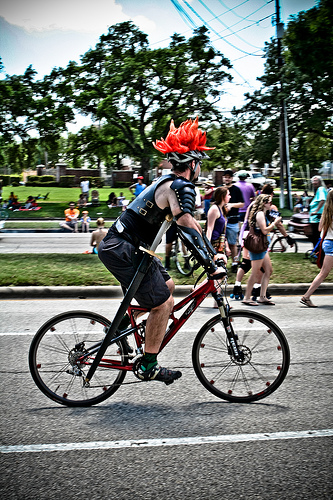

Description: A biker is racing to keep up with the runners




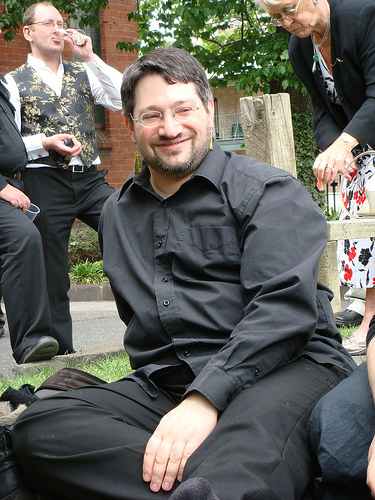

Description: A man wearing glasses and black clothing is sitting while a man in a vest drinks in the background .




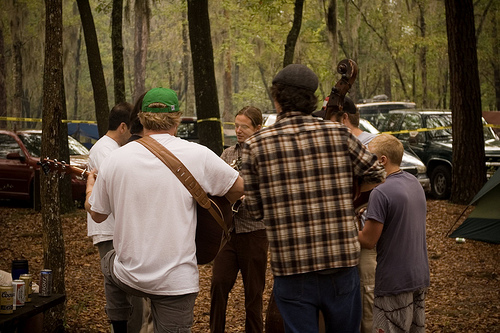

Description: A group of friends play instruments in the middle of the woods .




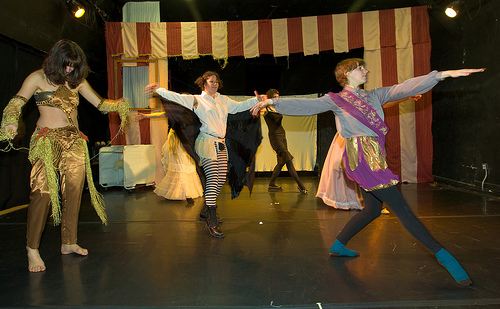

Description: A girl is wearing a purple sash and matching skirt .




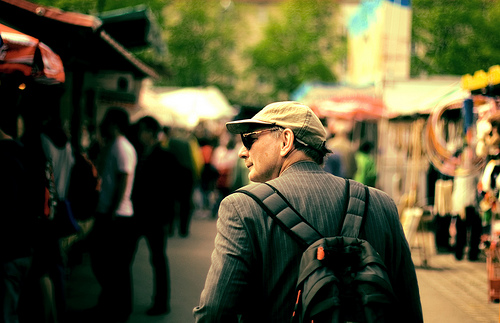

Description: A man , seen from the back , with his head turned to the side wearing a backpack




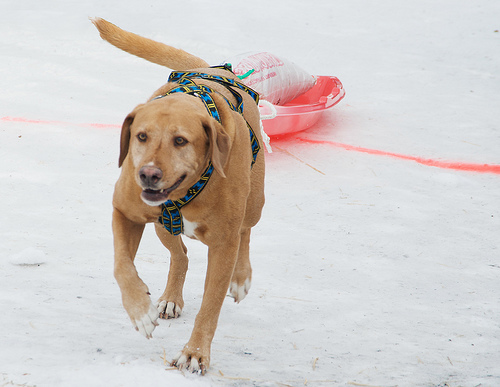

Description: A dog in a harness pulling a pink carrier behind it on snow .




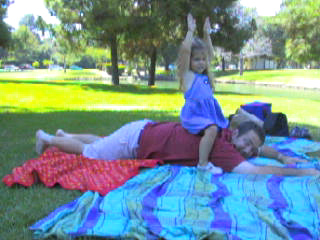

Description: A little girl playing piggyback with her father on a blanket in the park .




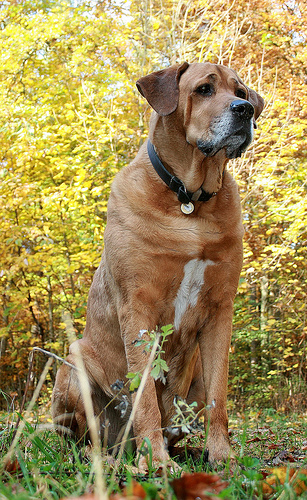

Description: A brown dog with a black collar stands next to a bush .




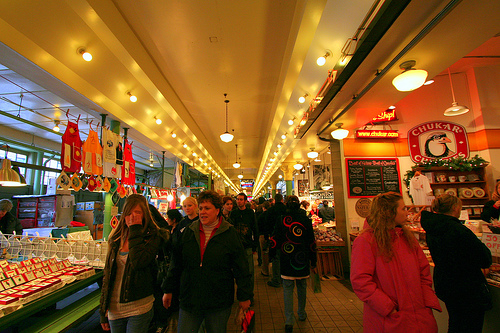

Description: A group of people walk through a shopping mall .




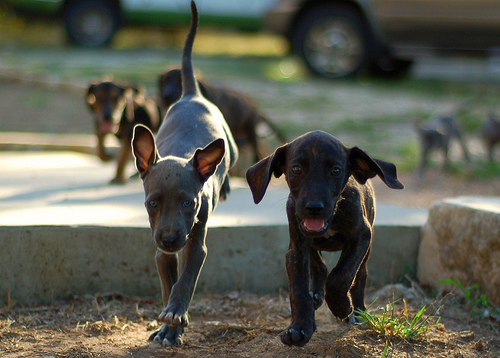

Description: A group of dogs walk around outdoors .




In [26]:
# Getting a list of unique images with maximum predicted scores
unique_images = vector_df_predict.drop_duplicates(subset='image', keep='first')

# Selecting 10 random images
random_samples = unique_images.sample(10)

# Displaying each image with its description
for _, row in random_samples.iterrows():
    image_name = row['image']
    image_path = os.path.join(TEST_DATA_PATH, str(image_name))
    image = Image.open(image_path)
    description = test_query[test_query['image'] == image_name]['query_text'].values[0]

    display(image)
    print("Description:", description)
    print("\n")

В данной работе мы провели следующие шаги:

1. Загрузили и изучили исходные данные, включая экспертные и краудсорсинговые оценки, а также обучающий и тестовый датасеты.
2. Преобразовали оценки качества описаний к единому формату, масштабируя их от 0 до 1.
3. Проверили работоспособность метода сопоставления изображений, описаний и оценок.
4. Удалили из тренировочной выборки все изображения, содержащие ключевые слова, связанные с детьми.
5. Векторизировали изображения и описания для обучающей выборки, используя модель ResNet-18 и TfidfVectorizer соответственно.
6. Обучили несколько моделей, включая логистическую регрессию, случайный лес, градиентный бустинг и нейронную сеть.
7. Подобрали лучшие гиперпараметры для модели случайного леса, добившись снижения значения MSE.
8. Протестировали модель на тестовой выборке и получили хорошие результаты.
9. Провели анализ описаний на наличие ключевых слов, связанных с детьми, и удалили соответствующие изображения из тренировочной выборки.

Выводы:

- Мы успешно применили метод агрегации оценок экспертов и краудсорсинга для оценки качества описаний.
- Использовали различные методы для векторизации изображений и текстовых описаний.
- Обучили и протестировали несколько моделей, выбрав наилучшую для данной задачи.
- Полученные результаты свидетельствуют о хорошей работоспособности выбранной модели.

Для улучшения работы можно было бы обучить модель компьютерного зрения для точного обнаружения детей на изображениях, что позволило бы избежать потенциальных юридических проблем.

## 8. Выводы

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска